In [1]:
!unzip layanalysiz2.zip

Archive:  layanalysiz2.zip
   creating: layanalysiz/
   creating: layanalysiz/images/
  inflating: layanalysiz/images/utp-0110-014r.jpg  
  inflating: layanalysiz/images/utp-0110-014v.jpg  
  inflating: layanalysiz/images/utp-0110-015v.jpg  
  inflating: layanalysiz/images/utp-0110-016r.jpg  
  inflating: layanalysiz/images/utp-0110-016v.jpg  
  inflating: layanalysiz/images/utp-0110-017v.jpg  
  inflating: layanalysiz/images/utp-0110-018r.jpg  
  inflating: layanalysiz/images/utp-0110-018v.jpg  
  inflating: layanalysiz/images/utp-0110-019v.jpg  
  inflating: layanalysiz/images/utp-0110-021r.jpg  
  inflating: layanalysiz/images/utp-0110-021v.jpg  
  inflating: layanalysiz/images/utp-0110-022r.jpg  
  inflating: layanalysiz/images/utp-0110-022v.jpg  
  inflating: layanalysiz/images/utp-0110-023r.jpg  
  inflating: layanalysiz/images/utp-0110-023v.jpg  
  inflating: layanalysiz/images/utp-0110-024r.jpg  
  inflating: layanalysiz/images/utp-0110-025v.jpg  
  inflating: layanalysiz/image

In [2]:
import cv2
import numpy as np
import os
import glob

input_folder_path = '/content/layanalysiz/masks_png'
output_folder_path = '/content/layanalysiz/masks_without_yellow'

image_files = sorted(glob.glob(os.path.join(input_folder_path, '*.png')))  # Uzantıyı değiştirebilirsin

for image_file in image_files:
    image_rgb = cv2.imread(image_file)

    yellow_rgb = np.array([0, 255, 255])

    mask_yellow = np.all(image_rgb == yellow_rgb, axis=-1)

    image_rgb[mask_yellow] = [0, 0, 0]  # Black color in RGB format

    result_file = os.path.join(output_folder_path, os.path.basename(image_file))
    cv2.imwrite(result_file, image_rgb)
    print(f'Processed: {image_file} -> {result_file}')

print('All images processed and saved to the output folder.')


Processed: /content/layanalysiz/masks_png/utp-0110-014r.png -> /content/layanalysiz/masks_without_yellow/utp-0110-014r.png
Processed: /content/layanalysiz/masks_png/utp-0110-014v.png -> /content/layanalysiz/masks_without_yellow/utp-0110-014v.png
Processed: /content/layanalysiz/masks_png/utp-0110-015v.png -> /content/layanalysiz/masks_without_yellow/utp-0110-015v.png
Processed: /content/layanalysiz/masks_png/utp-0110-016r.png -> /content/layanalysiz/masks_without_yellow/utp-0110-016r.png
Processed: /content/layanalysiz/masks_png/utp-0110-016v.png -> /content/layanalysiz/masks_without_yellow/utp-0110-016v.png
Processed: /content/layanalysiz/masks_png/utp-0110-017v.png -> /content/layanalysiz/masks_without_yellow/utp-0110-017v.png
Processed: /content/layanalysiz/masks_png/utp-0110-018r.png -> /content/layanalysiz/masks_without_yellow/utp-0110-018r.png
Processed: /content/layanalysiz/masks_png/utp-0110-018v.png -> /content/layanalysiz/masks_without_yellow/utp-0110-018v.png
Processed: /cont

In [3]:
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt


n_classes=6 #Number of classes for segmentation

train_images = []

for directory_path in glob.glob("/content/layanalysiz/images/"):
    for img_path in sorted(glob.glob(os.path.join(directory_path, "*.jpg"))):
        img_bgr = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        train_images.append(img_rgb)

train_images = np.array(train_images)

train_masks = []
for directory_path in glob.glob("/content/layanalysiz/masks_without_yellow/"):
    for mask_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        mask = cv2.imread(mask_path, 0)
        train_masks.append(mask)

train_masks = np.array(train_masks)

In [4]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)

train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3, 4, 5])

In [5]:

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 1/9, random_state = 0)

print("Class values in the dataset are ... ", np.unique(y_train))

from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

val_masks_cat = to_categorical(y_val, num_classes=n_classes)
y_val_cat = val_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

Class values in the dataset are ...  [0 1 2 3 4 5]


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes = np.unique(train_masks_reshaped_encoded), y = train_masks_reshaped_encoded)

print("Class weights are...:", class_weights)

Class weights are...: [0.5291277  2.10958403 1.19007064 1.25662289]


In [6]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [7]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate

def unet_16_model(n_classes=6, IMG_HEIGHT=960, IMG_WIDTH=640, IMG_CHANNELS=1):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contracting Path
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)

    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)

    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D(pool_size=(2, 2))(c3)

    c4 = Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottom
    c5 = Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # Expansive Path
    u6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = Conv2D(64, 3, activation='relu', padding='same')(c9)

    outputs = Conv2D(n_classes, (1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model



In [9]:
def get_model():
    return unet_16_model(n_classes=6, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 960, 640, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 960, 640, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 conv2d_20 (Conv2D)          (None, 960, 640, 64)         36928     ['conv2d_19[0][0]']           
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 480, 320, 64)         0         ['conv2d_20[0][0]']           
 g2D)                                                                                       

In [10]:
history = model.fit(X_train, y_train_cat,
                    batch_size = 4,
                    verbose=1,
                    epochs=60,
                    validation_data=(X_val, y_val_cat),
                    #class_weight=class_weights,
                    shuffle=False)

model.save('testb4e60rgbinputunet16.hdf5')

Epoch 1/60
20/20 [==============================] - 39s 420ms/step - loss: 6.0654 - accuracy: 0.5273 - val_loss: 0.7879 - val_accuracy: 0.7133
Epoch 2/60
20/20 [==============================] - 4s 214ms/step - loss: 0.6237 - accuracy: 0.8002 - val_loss: 0.5757 - val_accuracy: 0.8078
Epoch 3/60
20/20 [==============================] - 4s 214ms/step - loss: 0.4605 - accuracy: 0.8684 - val_loss: 0.4016 - val_accuracy: 0.8884
Epoch 4/60
20/20 [==============================] - 4s 216ms/step - loss: 0.3695 - accuracy: 0.8973 - val_loss: 0.3586 - val_accuracy: 0.9028
Epoch 5/60
20/20 [==============================] - 4s 216ms/step - loss: 0.3067 - accuracy: 0.9117 - val_loss: 0.3370 - val_accuracy: 0.9038
Epoch 6/60
20/20 [==============================] - 4s 215ms/step - loss: 0.2703 - accuracy: 0.9201 - val_loss: 0.2874 - val_accuracy: 0.9195
Epoch 7/60
20/20 [==============================] - 4s 215ms/step - loss: 0.3298 - accuracy: 0.9012 - val_loss: 0.3463 - val_accuracy: 0.8961
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 236ms/step - loss: 0.0219 - accuracy: 0.9922
Accuracy is =  99.21567440032959 %


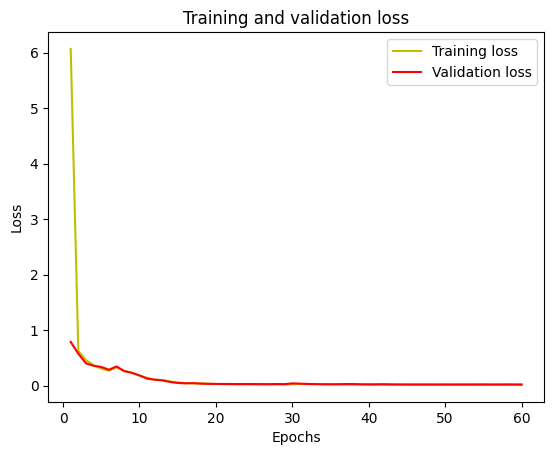

In [14]:
_, acc = model.evaluate(X_val, y_val_cat)
print("Accuracy is = ", (acc * 100.0), "%")



loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)


from keras.metrics import MeanIoU

n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)

IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
mean_iou = IOU_keras.result().numpy()
print("Mean IoU =", mean_iou)

values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)

class_iou = []
for i in range(n_classes):
    numerator = values[i, i]
    denominator = np.sum(values[i, :]) + np.sum(values[:, i]) - numerator
    class_iou.append(numerator / denominator)

for i in range(n_classes):
    print(f"IoU for class {i+1} is: {class_iou[i]}")

1/1 [==============================] - 11s 11s/step
Mean IoU = 0.9622124
[[4.027528e+06 1.366900e+04 2.828000e+03 2.093000e+03 2.117000e+03
  3.800000e+02]
 [1.766900e+04 7.167980e+05 0.000000e+00 8.000000e+00 0.000000e+00
  0.000000e+00]
 [5.720000e+03 0.000000e+00 1.199755e+06 0.000000e+00 1.000000e+00
  1.290000e+02]
 [8.970000e+02 2.600000e+01 9.000000e+00 5.949000e+04 4.000000e+00
  2.960000e+02]
 [1.682000e+03 2.500000e+01 0.000000e+00 0.000000e+00 6.487100e+04
  0.000000e+00]
 [8.310000e+02 0.000000e+00 7.000000e+00 0.000000e+00 0.000000e+00
  2.716700e+04]]
IoU for class 1 is: 0.9882500171661377
IoU for class 2 is: 0.9580363631248474
IoU for class 3 is: 0.9928056597709656
IoU for class 4 is: 0.9469462037086487
IoU for class 5 is: 0.9442649483680725
IoU for class 6 is: 0.9429711699485779


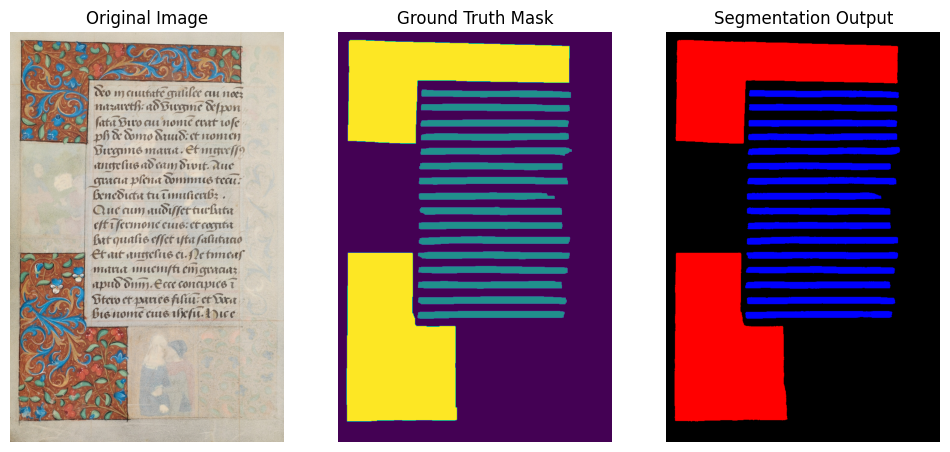

In [12]:
import numpy as np
import matplotlib.pyplot as plt


image_index = 2

original_image = X_test[image_index]
ground_truth_mask = y_test[image_index]
predicted_mask = y_pred[image_index]

output = (predicted_mask)

label_encoded_output = np.argmax(output, axis=-1)

colors = [
    [0, 0, 0],      # Black
    [0, 0, 255],    # Blue
    [255, 0, 0],    # Red
    [0, 255, 255],  # Cyan
    [0, 255, 0],    # Green
    [255, 0, 255],  # Magenta
]

height, width = label_encoded_output.shape
rgb_image = np.zeros((height, width, 3), dtype=np.uint8)

for i, color in enumerate(colors):
    mask = (label_encoded_output == i)
    rgb_image[mask] = color


plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(ground_truth_mask)
plt.title('Ground Truth Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(rgb_image)
plt.title("Segmentation Output")
plt.axis('off')
plt.show()